#LSC Project

##Set up

In [1]:
!pip install keras-tuner #Installing keras tuner-for hyperparameter optimisation

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from datetime import datetime
from kerastuner import HyperModel

plt.rcParams['savefig.transparent'] = True
np.set_printoptions(suppress=True)

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=b6f2509ba0a58204ae57f8977db9fd7c028c1a0cdf4bf8d87037897869b83406
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=795ca227abb85b687cfc1fc554c71c240fad22f62348a7bd81375bc6925be6ac
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
# Download CIFAR 100 with the 20 superclass labels 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='coarse') 

169009152/169001437 [==============================] - 4s 0us/step


In [ ]:
#Checking lengths
print('x_train length ' + str(len(x_train)))
print('x_test length ' + str(len(x_test)))

x_train length 50000
x_test length 10000


In [ ]:
#One hot encoding the target variables and standardising x inputs so they're
#between 0 and 1
y_input = tf.keras.utils.to_categorical(y_train)
x_input = (x_train / 255.0)

#Using test set as validation for simplicity
y_valid = tf.keras.utils.to_categorical(y_test)
x_valid = (x_test / 255.0)

#Checking shape
print('y_input shape ' + str(y_input.shape))
print('x_input shape ' + str(x_input.shape))

y_input shape (50000, 20)
x_input shape (50000, 32, 32, 3)


In [ ]:
#Creating descriptive labels for reference
coarse_labels = [
'aquatic mammals',
'fish',
'flowers',
'food containers',
'fruit and vegetables',
'household electrical device',
'household furniture',
'insects',
'large carnivores',
'large man-made outdoor things',
'large natural outdoor scenes',
'large omnivores and herbivores',
'medium-sized mammals',
'non-insect invertebrates',
'people',
'reptiles',
'small mammals',
'trees',
'vehicles 1',
'vehicles 2',
]

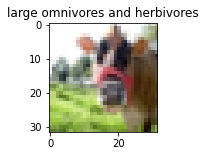

In [ ]:
#Example image coarse
i=0
label = y_train[i]
image = x_train[i]
plt.figure(figsize=(2,2))
plt.grid(False)
plt.title((coarse_labels[int(label)]))
plt.imshow(image)
plt.show()

In [9]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

##Part 1 – Building an initial model to predict coarse labels

###Building initial model with adam optimizer

In [ ]:
#Setting up logging files
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

#Creating layers
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same',
  input_shape=( 32, 32, 3)))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))

model.add(tf.keras.layers.Dense(units=20,activation=tf.nn.softmax))

#Compiling model using an Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

#Recording model checkpoints
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#Logging to tensorboard
tb_log = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#Creating early stopping where validation loss does not improve
#early_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

#Save best model weights based on validation accuracy
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

callbacks = [tb_log,
             #early_loss,
             mcp_save]

In [ ]:
#Fitting model
model.fit(x_input, y_input, epochs=100,
  batch_size=32,
  callbacks=callbacks,
  validation_data=(x_valid, y_valid))

Epoch 1/10
 311/1563 [====>.........................] - ETA: 5s - loss: 2.5842 - accuracy: 0.2092

KeyboardInterrupt: ignored

In [ ]:
#Returning best weights
model.load_weights(filepath = '.mdl_wts.hdf5')

#Recording test accuracy
predictions = model.predict(x_valid)
y_pred = np.argmax(predictions,axis=-1)
print('test accuracy: ', np.sum(y_pred==y_test[:,0])/len(y_test))
## test accuracy: 0.4801

test accuracy:  0.4851


In [ ]:
#Examining loss on TensorBoard
%tensorboard --logdir logs/scalars

UsageError: Line magic function `%tensorboard` not found.


###Building model with stochastic gradient descent optimizer


In [ ]:
#Setting up logging files
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

#Creating layers
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same',
  input_shape=( 32, 32, 3)))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))

model.add(tf.keras.layers.Dense(units=20,activation=tf.nn.softmax))

#Compiling model using a SGD optimizer
model.compile(optimizer=tf.keras.optimizers.SGD(0.001),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

#Recording model checkpoints
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#Logging to tensorboard
tb_log = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#Creating early stopping where validation loss does not improve
#early_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

#Save best model weights based on validation accuracy
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

callbacks = [tb_log,
             #early_loss,
             mcp_save]

In [ ]:
#Fitting model
model.fit(x_input, y_input, epochs=100,
  batch_size=32,
  callbacks=callbacks,
  validation_data=(x_valid, y_valid))

Epoch 1/100
1563/1563 [==============================] - 8s 5ms/step - loss: 2.9209 - accuracy: 0.1094 - val_loss: 2.8166 - val_accuracy: 0.1430
Epoch 2/100
1563/1563 [==============================] - 8s 5ms/step - loss: 2.7114 - accuracy: 0.1687 - val_loss: 2.6512 - val_accuracy: 0.1832
Epoch 3/100
1563/1563 [==============================] - 8s 5ms/step - loss: 2.6000 - accuracy: 0.2065 - val_loss: 2.5740 - val_accuracy: 0.2156
Epoch 4/100
1563/1563 [==============================] - 8s 5ms/step - loss: 2.5382 - accuracy: 0.2256 - val_loss: 2.5291 - val_accuracy: 0.2251
Epoch 5/100
1563/1563 [==============================] - 8s 5ms/step - loss: 2.4903 - accuracy: 0.2391 - val_loss: 2.4940 - val_accuracy: 0.2324
Epoch 6/100
1563/1563 [==============================] - 8s 5ms/step - loss: 2.4482 - accuracy: 0.2525 - val_loss: 2.4480 - val_accuracy: 0.2502
Epoch 7/100
1563/1563 [==============================] - 8s 5ms/step - loss: 2.4129 - accuracy: 0.2617 - val_loss: 2.4220 - val_ac

In [ ]:
#Returning best weights
model.load_weights(filepath = '.mdl_wts.hdf5')

#Recording test accuracy
predictions = model.predict(x_valid)
y_pred = np.argmax(predictions,axis=-1)
print('test accuracy: ', np.sum(y_pred==y_test[:,0])/len(y_test))
## test accuracy: 0.4692

test accuracy:  0.4692


In [ ]:
#Examining loss on TensorBoard
%tensorboard --logdir logs/scalars

###Building 16 batch model

In [ ]:
#Setting up logging files
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

#Creating layers
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same',
  input_shape=( 32, 32, 3)))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))

model.add(tf.keras.layers.Dense(units=20,activation=tf.nn.softmax))

#Compiling model using an Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

#Recording model checkpoints
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#Logging to tensorboard
tb_log = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#Creating early stopping where validation loss does not improve
#early_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

#Save best model weights based on validation accuracy
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

callbacks = [tb_log,
             #early_loss,
             mcp_save]

In [ ]:
#Fitting model
model.fit(x_input, y_input, epochs=20,
  batch_size=16,
  callbacks=callbacks,
  validation_data=(x_valid, y_valid))

Epoch 1/20
3125/3125 [==============================] - 14s 4ms/step - loss: 2.2541 - accuracy: 0.3052 - val_loss: 2.0142 - val_accuracy: 0.3781
Epoch 2/20
3125/3125 [==============================] - 14s 4ms/step - loss: 1.8180 - accuracy: 0.4355 - val_loss: 1.7878 - val_accuracy: 0.4465
Epoch 3/20
3125/3125 [==============================] - 14s 4ms/step - loss: 1.5584 - accuracy: 0.5141 - val_loss: 1.7344 - val_accuracy: 0.4693
Epoch 4/20
3125/3125 [==============================] - 14s 4ms/step - loss: 1.3326 - accuracy: 0.5808 - val_loss: 1.7745 - val_accuracy: 0.4790
Epoch 5/20
3125/3125 [==============================] - 14s 4ms/step - loss: 1.1141 - accuracy: 0.6459 - val_loss: 1.9183 - val_accuracy: 0.4672
Epoch 6/20
3125/3125 [==============================] - 14s 4ms/step - loss: 0.8979 - accuracy: 0.7140 - val_loss: 2.1897 - val_accuracy: 0.4435
Epoch 7/20
3125/3125 [==============================] - 14s 4ms/step - loss: 0.7005 - accuracy: 0.7755 - val_loss: 2.4559 - val_ac

In [ ]:
#Returning best weights
model.load_weights(filepath = '.mdl_wts.hdf5')

#Recording test accuracy
predictions = model.predict(x_valid)
y_pred = np.argmax(predictions,axis=-1)
print('test accuracy: ', np.sum(y_pred==y_test[:,0])/len(y_test))
## test accuracy: 0.479

test accuracy:  0.479


In [ ]:
#Examining loss on TensorBoard
%tensorboard --logdir logs/scalars

###Building 64 batch model

In [ ]:
#Setting up logging files
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

#Creating layers
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same',
  input_shape=( 32, 32, 3)))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))

model.add(tf.keras.layers.Dense(units=20,activation=tf.nn.softmax))

#Compiling model using an Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

#Recording model checkpoints
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#Logging to tensorboard
tb_log = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#Creating early stopping where validation loss does not improve
#early_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

#Save best model weights based on validation accuracy
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

callbacks = [tb_log,
             #early_loss,
             mcp_save]

In [ ]:
#Fitting model
model.fit(x_input, y_input, epochs=20,
  batch_size=64,
  callbacks=callbacks,
  validation_data=(x_valid, y_valid))

Epoch 1/20
782/782 [==============================] - 5s 6ms/step - loss: 2.2771 - accuracy: 0.3005 - val_loss: 2.0184 - val_accuracy: 0.3797
Epoch 2/20
782/782 [==============================] - 5s 6ms/step - loss: 1.8194 - accuracy: 0.4385 - val_loss: 1.8106 - val_accuracy: 0.4408
Epoch 3/20
782/782 [==============================] - 5s 6ms/step - loss: 1.5895 - accuracy: 0.5063 - val_loss: 1.8412 - val_accuracy: 0.4449
Epoch 4/20
782/782 [==============================] - 5s 6ms/step - loss: 1.3961 - accuracy: 0.5644 - val_loss: 1.7145 - val_accuracy: 0.4765
Epoch 5/20
782/782 [==============================] - 5s 6ms/step - loss: 1.2284 - accuracy: 0.6136 - val_loss: 1.6701 - val_accuracy: 0.4963
Epoch 6/20
782/782 [==============================] - 5s 6ms/step - loss: 1.0473 - accuracy: 0.6689 - val_loss: 1.7936 - val_accuracy: 0.4862
Epoch 7/20
782/782 [==============================] - 5s 6ms/step - loss: 0.8753 - accuracy: 0.7215 - val_loss: 1.9004 - val_accuracy: 0.4888
Epoch 

In [ ]:
#Returning best weights
model.load_weights(filepath = '.mdl_wts.hdf5')

#Recording test accuracy
predictions = model.predict(x_valid)
y_pred = np.argmax(predictions,axis=-1)
print('test accuracy: ', np.sum(y_pred==y_test[:,0])/len(y_test))
## test accuracy: 0.4963

test accuracy:  0.4963


In [ ]:
#Examining loss on TensorBoard
%tensorboard --logdir logs/scalars

###Building a smaller learning rate model (1e-4)

In [ ]:
#Setting up logging files
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

#Creating layers
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same',
  input_shape=( 32, 32, 3)))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))

model.add(tf.keras.layers.Dense(units=20,activation=tf.nn.softmax))

#Compiling model using an Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

#Recording model checkpoints
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#Logging to tensorboard
tb_log = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#Creating early stopping where validation loss does not improve
#early_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

#Save best model weights based on validation accuracy
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

callbacks = [tb_log,
             #early_loss,
             mcp_save]

#Fitting model
model.fit(x_input, y_input, epochs=100,
  batch_size=64,
  callbacks=callbacks,
  validation_data=(x_valid, y_valid))

#Returning best weights
model.load_weights(filepath = '.mdl_wts.hdf5')

#Recording test accuracy
predictions = model.predict(x_valid)
y_pred = np.argmax(predictions,axis=-1)
print('test accuracy: ', np.sum(y_pred==y_test[:,0])/len(y_test))
## test accuracy: 0.4963


Epoch 1/100
782/782 [==============================] - 5s 6ms/step - loss: 2.5121 - accuracy: 0.2356 - val_loss: 2.3127 - val_accuracy: 0.2945
Epoch 2/100
782/782 [==============================] - 5s 6ms/step - loss: 2.2011 - accuracy: 0.3311 - val_loss: 2.1636 - val_accuracy: 0.3365
Epoch 3/100
782/782 [==============================] - 5s 6ms/step - loss: 2.0760 - accuracy: 0.3677 - val_loss: 2.1281 - val_accuracy: 0.3423
Epoch 4/100
782/782 [==============================] - 5s 6ms/step - loss: 1.9865 - accuracy: 0.3941 - val_loss: 2.0232 - val_accuracy: 0.3818
Epoch 5/100
782/782 [==============================] - 5s 6ms/step - loss: 1.9155 - accuracy: 0.4155 - val_loss: 1.9807 - val_accuracy: 0.3941
Epoch 6/100
782/782 [==============================] - 5s 6ms/step - loss: 1.8535 - accuracy: 0.4338 - val_loss: 1.9313 - val_accuracy: 0.4112
Epoch 7/100
782/782 [==============================] - 5s 6ms/step - loss: 1.8012 - accuracy: 0.4500 - val_loss: 1.9081 - val_accuracy: 0.4198

In [ ]:
#Examining loss on TensorBoard
%tensorboard --logdir logs/scalars

###Building a larger learning rate model (1e-2)

In [ ]:
#Setting up logging files
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

#Creating layers
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same',
  input_shape=( 32, 32, 3)))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))
2
model.add(tf.keras.layers.Dense(units=20,activation=tf.nn.softmax))

#Compiling model using an Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

#Recording model checkpoints
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#Logging to tensorboard
tb_log = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#Creating early stopping where validation loss does not improve
#early_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

#Save best model weights based on validation accuracy
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

callbacks = [tb_log,
             #early_loss,
             mcp_save]

#Fitting model
model.fit(x_input, y_input, epochs=100,
  batch_size=64,
  callbacks=callbacks,
  validation_data=(x_valid, y_valid))

#Returning best weights
model.load_weights(filepath = '.mdl_wts.hdf5')

#Recording test accuracy
predictions = model.predict(x_valid)
y_pred = np.argmax(predictions,axis=-1)
print('test accuracy: ', np.sum(y_pred==y_test[:,0])/len(y_test))
## test accuracy: 0.4963


Epoch 1/100
782/782 [==============================] - 5s 7ms/step - loss: 3.0319 - accuracy: 0.0512 - val_loss: 2.9967 - val_accuracy: 0.0500
Epoch 2/100
782/782 [==============================] - 5s 6ms/step - loss: 2.9973 - accuracy: 0.0485 - val_loss: 2.9965 - val_accuracy: 0.0500
Epoch 3/100
782/782 [==============================] - 5s 6ms/step - loss: 2.9972 - accuracy: 0.0508 - val_loss: 2.9969 - val_accuracy: 0.0500
Epoch 4/100
782/782 [==============================] - 5s 6ms/step - loss: 2.9972 - accuracy: 0.0490 - val_loss: 2.9970 - val_accuracy: 0.0500
Epoch 5/100
782/782 [==============================] - 5s 6ms/step - loss: 2.9973 - accuracy: 0.0496 - val_loss: 2.9968 - val_accuracy: 0.0500
Epoch 6/100
782/782 [==============================] - 5s 6ms/step - loss: 2.9971 - accuracy: 0.0491 - val_loss: 2.9970 - val_accuracy: 0.0500
Epoch 7/100
782/782 [==============================] - 4s 6ms/step - loss: 2.9975 - accuracy: 0.0500 - val_loss: 2.9969 - val_accuracy: 0.0500

KeyboardInterrupt: ignored

In [ ]:
#Examining loss on TensorBoard
%tensorboard --logdir logs/scalars

##Part 2 - Optimising the model architecture

###Adding in drop out layers

In [55]:
#Setting up logging files
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

#Creating layers
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same',
  input_shape=( 32, 32, 3)))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(units=20,activation=tf.nn.softmax))

#Compiling model using an Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

#Recording model checkpoints
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#Logging to tensorboard
tb_log = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#Creating early stopping where validation loss does not improve
#early_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

#Save best model weights based on validation accuracy
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

callbacks = [tb_log,
             #early_loss,
             mcp_save]

#Fitting model
model.fit(x_input, y_input, epochs=100,
  batch_size=64,
  callbacks=callbacks,
  validation_data=(x_valid, y_valid))

#Returning best weights
model.load_weights(filepath = '.mdl_wts.hdf5')

#Recording test accuracy
predictions = model.predict(x_valid)
y_pred = np.argmax(predictions,axis=-1)
print('test accuracy: ', np.sum(y_pred==y_test[:,0])/len(y_test))
## test accuracy: 0.5132

Epoch 1/100
782/782 [==============================] - 6s 8ms/step - loss: 2.5985 - accuracy: 0.1966 - val_loss: 2.2589 - val_accuracy: 0.3192
Epoch 2/100
782/782 [==============================] - 5s 7ms/step - loss: 2.3186 - accuracy: 0.2856 - val_loss: 2.0883 - val_accuracy: 0.3711
Epoch 3/100
291/782 [==========>...................] - ETA: 2s - loss: 2.2173 - accuracy: 0.3170

KeyboardInterrupt: ignored

In [ ]:
#Examining loss on TensorBoard
%tensorboard --logdir logs/scalars

###Adding in convolutional layers

In [ ]:
#Setting up logging files
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

#Creating layers
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same',
  input_shape=( 32, 32, 3)))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same',
  input_shape=( 32, 32, 3)))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same'))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(units=20,activation=tf.nn.softmax))

#Compiling model using an Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

#Recording model checkpoints
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#Logging to tensorboard
tb_log = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#Creating early stopping where validation loss does not improve
#early_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

#Save best model weights based on validation accuracy
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

callbacks = [tb_log,
             #early_loss,
             mcp_save]

#Fitting model
model.fit(x_input, y_input, epochs=100,
  batch_size=64,
  callbacks=callbacks,
  validation_data=(x_valid, y_valid))

#Returning best weights
model.load_weights(filepath = '.mdl_wts.hdf5')

#Recording test accuracy
predictions = model.predict(x_valid)
y_pred = np.argmax(predictions,axis=-1)
print('test accuracy: ', np.sum(y_pred==y_test[:,0])/len(y_test))
## test accuracy: 0.5515

Epoch 1/100
782/782 [==============================] - 7s 9ms/step - loss: 2.5993 - accuracy: 0.1954 - val_loss: 2.2612 - val_accuracy: 0.2963
Epoch 2/100
782/782 [==============================] - 7s 8ms/step - loss: 2.2868 - accuracy: 0.2916 - val_loss: 2.0199 - val_accuracy: 0.3814
Epoch 3/100
782/782 [==============================] - 7s 9ms/step - loss: 2.1138 - accuracy: 0.3446 - val_loss: 1.8833 - val_accuracy: 0.4146
Epoch 4/100
782/782 [==============================] - 7s 9ms/step - loss: 1.9889 - accuracy: 0.3823 - val_loss: 1.7880 - val_accuracy: 0.4435
Epoch 5/100
782/782 [==============================] - 7s 9ms/step - loss: 1.8966 - accuracy: 0.4054 - val_loss: 1.7386 - val_accuracy: 0.4555
Epoch 6/100
782/782 [==============================] - 7s 8ms/step - loss: 1.8083 - accuracy: 0.4325 - val_loss: 1.6640 - val_accuracy: 0.4825
Epoch 7/100
782/782 [==============================] - 7s 9ms/step - loss: 1.7392 - accuracy: 0.4507 - val_loss: 1.6369 - val_accuracy: 0.4884

In [ ]:
#Examining loss on TensorBoard
%tensorboard --logdir logs/scalars

###Optimizing hyperparameters

In [84]:
#Storing the model for random search
def build_model(hp):
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(filters=hp.Choice(
        'first_layer_filters',
        values=[16,32,64],
        default=32
    ), kernel_size=(3,3),
    activation=tf.nn.relu,padding='same',
    input_shape=( 32, 32, 3)))

  model.add(tf.keras.layers.Conv2D(filters=hp.Choice(
        'second_layer_filters',
        values=[16,32,64],
        default=32
    ), kernel_size=(3,3),
    activation=tf.nn.relu,padding='same',
    input_shape=( 32, 32, 3)))

  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Conv2D(filters=hp.Choice(
        'third_layer_filters',
        values=[32,64,128],
        default=64
    ), kernel_size=(3,3),
    activation=tf.nn.relu,padding='same'))

  model.add(tf.keras.layers.Conv2D(filters=hp.Choice(
        'fourth_layer_filters',
        values=[32,64,128],
        default=64
    ), kernel_size=(3,3),
    activation=tf.nn.relu,padding='same'))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Dense(units=hp.Choice(
        'dense_units',
        values=[64,128,256],
        default=128
    ), activation=tf.nn.relu))

  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Dense(units=20,activation=tf.nn.softmax))

  #Compiling model using an Adam optimizer
  model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
  
  return model

In [85]:
from kerastuner.tuners import RandomSearch

#Storing random search parameters
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    seed=42,
    max_trials=10,
    executions_per_trial=1,
    directory='random_search',
    project_name='cifar20'
)

INFO:tensorflow:Reloading Oracle from existing project random_search/cifar20/oracle.json
INFO:tensorflow:Reloading Tuner from random_search/cifar20/tuner0.json


In [86]:
#Random search
tuner.search(x_input, y_input,
             epochs=50,
             batch_size=64,
             validation_data=(x_valid, y_valid))

#Printing 'best' model performance
print(tuner.get_best_models()[0].summary())
print(tuner.get_best_hyperparameters()[0].values)

Epoch 1/50
782/782 [==============================] - 6s 8ms/step - loss: 2.6185 - accuracy: 0.1893 - val_loss: 2.3249 - val_accuracy: 0.2938
Epoch 2/50
782/782 [==============================] - 6s 8ms/step - loss: 2.2826 - accuracy: 0.2943 - val_loss: 2.0122 - val_accuracy: 0.3826
Epoch 3/50
782/782 [==============================] - 6s 8ms/step - loss: 2.1089 - accuracy: 0.3490 - val_loss: 1.9080 - val_accuracy: 0.4028
Epoch 4/50
782/782 [==============================] - 6s 8ms/step - loss: 1.9792 - accuracy: 0.3821 - val_loss: 1.7757 - val_accuracy: 0.4487
Epoch 5/50
782/782 [==============================] - 6s 8ms/step - loss: 1.8784 - accuracy: 0.4143 - val_loss: 1.7130 - val_accuracy: 0.4633
Epoch 6/50
782/782 [==============================] - 6s 8ms/step - loss: 1.7948 - accuracy: 0.4396 - val_loss: 1.7104 - val_accuracy: 0.4648
Epoch 7/50
782/782 [==============================] - 6s 8ms/step - loss: 1.7144 - accuracy: 0.4577 - val_loss: 1.6159 - val_accuracy: 0.4982
Epoch 

Epoch 1/50
782/782 [==============================] - 6s 8ms/step - loss: 2.6279 - accuracy: 0.1865 - val_loss: 2.3129 - val_accuracy: 0.2893
Epoch 2/50
782/782 [==============================] - 6s 7ms/step - loss: 2.3225 - accuracy: 0.2846 - val_loss: 2.1374 - val_accuracy: 0.3381
Epoch 3/50
782/782 [==============================] - 6s 7ms/step - loss: 2.1558 - accuracy: 0.3293 - val_loss: 1.9362 - val_accuracy: 0.3895
Epoch 4/50
782/782 [==============================] - 6s 7ms/step - loss: 2.0510 - accuracy: 0.3606 - val_loss: 1.8779 - val_accuracy: 0.4198
Epoch 5/50
782/782 [==============================] - 6s 7ms/step - loss: 1.9575 - accuracy: 0.3917 - val_loss: 1.7777 - val_accuracy: 0.4513
Epoch 6/50
782/782 [==============================] - 6s 7ms/step - loss: 1.8762 - accuracy: 0.4122 - val_loss: 1.7394 - val_accuracy: 0.4563
Epoch 7/50
782/782 [==============================] - 6s 7ms/step - loss: 1.8091 - accuracy: 0.4326 - val_loss: 1.6834 - val_accuracy: 0.4773
Epoch 

Epoch 1/50
782/782 [==============================] - 6s 8ms/step - loss: 2.5271 - accuracy: 0.2158 - val_loss: 2.2249 - val_accuracy: 0.3106
Epoch 2/50
782/782 [==============================] - 6s 8ms/step - loss: 2.1904 - accuracy: 0.3241 - val_loss: 2.0085 - val_accuracy: 0.3863
Epoch 3/50
782/782 [==============================] - 6s 8ms/step - loss: 2.0204 - accuracy: 0.3754 - val_loss: 1.8890 - val_accuracy: 0.4166
Epoch 4/50
782/782 [==============================] - 6s 8ms/step - loss: 1.8980 - accuracy: 0.4075 - val_loss: 1.7839 - val_accuracy: 0.4430
Epoch 5/50
782/782 [==============================] - 6s 8ms/step - loss: 1.7998 - accuracy: 0.4387 - val_loss: 1.7369 - val_accuracy: 0.4569
Epoch 6/50
782/782 [==============================] - 6s 8ms/step - loss: 1.7089 - accuracy: 0.4643 - val_loss: 1.6898 - val_accuracy: 0.4762
Epoch 7/50
782/782 [==============================] - 6s 8ms/step - loss: 1.6321 - accuracy: 0.4865 - val_loss: 1.6411 - val_accuracy: 0.4908
Epoch 

Epoch 1/50
782/782 [==============================] - 7s 8ms/step - loss: 2.5554 - accuracy: 0.2087 - val_loss: 2.3108 - val_accuracy: 0.2888
Epoch 2/50
782/782 [==============================] - 6s 8ms/step - loss: 2.2109 - accuracy: 0.3206 - val_loss: 2.1146 - val_accuracy: 0.3481
Epoch 3/50
782/782 [==============================] - 6s 8ms/step - loss: 2.0373 - accuracy: 0.3704 - val_loss: 1.9261 - val_accuracy: 0.4064
Epoch 4/50
782/782 [==============================] - 6s 8ms/step - loss: 1.9107 - accuracy: 0.4061 - val_loss: 1.8232 - val_accuracy: 0.4381
Epoch 5/50
782/782 [==============================] - 6s 8ms/step - loss: 1.8108 - accuracy: 0.4352 - val_loss: 1.7922 - val_accuracy: 0.4489
Epoch 6/50
782/782 [==============================] - 6s 8ms/step - loss: 1.7219 - accuracy: 0.4596 - val_loss: 1.7197 - val_accuracy: 0.4663
Epoch 7/50
782/782 [==============================] - 6s 8ms/step - loss: 1.6436 - accuracy: 0.4816 - val_loss: 1.6752 - val_accuracy: 0.4881
Epoch 

Epoch 1/50
782/782 [==============================] - 6s 7ms/step - loss: 2.5262 - accuracy: 0.2190 - val_loss: 2.2733 - val_accuracy: 0.2999
Epoch 2/50
782/782 [==============================] - 6s 7ms/step - loss: 2.1785 - accuracy: 0.3283 - val_loss: 1.9705 - val_accuracy: 0.3934
Epoch 3/50
782/782 [==============================] - 6s 7ms/step - loss: 2.0054 - accuracy: 0.3800 - val_loss: 1.8131 - val_accuracy: 0.4358
Epoch 4/50
782/782 [==============================] - 6s 7ms/step - loss: 1.8793 - accuracy: 0.4165 - val_loss: 1.7412 - val_accuracy: 0.4567
Epoch 5/50
782/782 [==============================] - 6s 7ms/step - loss: 1.7861 - accuracy: 0.4423 - val_loss: 1.6768 - val_accuracy: 0.4755
Epoch 6/50
782/782 [==============================] - 6s 7ms/step - loss: 1.6972 - accuracy: 0.4677 - val_loss: 1.6322 - val_accuracy: 0.4911
Epoch 7/50
782/782 [==============================] - 6s 7ms/step - loss: 1.6312 - accuracy: 0.4864 - val_loss: 1.6134 - val_accuracy: 0.4934
Epoch 

Epoch 1/50
782/782 [==============================] - 6s 7ms/step - loss: 2.5378 - accuracy: 0.2158 - val_loss: 2.1920 - val_accuracy: 0.3276
Epoch 2/50
782/782 [==============================] - 6s 7ms/step - loss: 2.2050 - accuracy: 0.3215 - val_loss: 2.0245 - val_accuracy: 0.3777
Epoch 3/50
782/782 [==============================] - 6s 7ms/step - loss: 2.0260 - accuracy: 0.3716 - val_loss: 1.8382 - val_accuracy: 0.4290
Epoch 4/50
782/782 [==============================] - 6s 7ms/step - loss: 1.8912 - accuracy: 0.4108 - val_loss: 1.7482 - val_accuracy: 0.4599
Epoch 5/50
782/782 [==============================] - 6s 7ms/step - loss: 1.7654 - accuracy: 0.4494 - val_loss: 1.6670 - val_accuracy: 0.4832
Epoch 6/50
782/782 [==============================] - 6s 7ms/step - loss: 1.6652 - accuracy: 0.4746 - val_loss: 1.6501 - val_accuracy: 0.4879
Epoch 7/50
782/782 [==============================] - 6s 7ms/step - loss: 1.5697 - accuracy: 0.5066 - val_loss: 1.6320 - val_accuracy: 0.4960
Epoch 

Epoch 1/50
782/782 [==============================] - 6s 7ms/step - loss: 2.6230 - accuracy: 0.1843 - val_loss: 2.3789 - val_accuracy: 0.2640
Epoch 2/50
782/782 [==============================] - 5s 7ms/step - loss: 2.3334 - accuracy: 0.2818 - val_loss: 2.0967 - val_accuracy: 0.3510
Epoch 3/50
782/782 [==============================] - 5s 7ms/step - loss: 2.1961 - accuracy: 0.3223 - val_loss: 1.9811 - val_accuracy: 0.3911
Epoch 4/50
782/782 [==============================] - 5s 7ms/step - loss: 2.0918 - accuracy: 0.3542 - val_loss: 1.9048 - val_accuracy: 0.4131
Epoch 5/50
782/782 [==============================] - 5s 7ms/step - loss: 2.0004 - accuracy: 0.3802 - val_loss: 1.8373 - val_accuracy: 0.4287
Epoch 6/50
782/782 [==============================] - 5s 7ms/step - loss: 1.9361 - accuracy: 0.3958 - val_loss: 1.7757 - val_accuracy: 0.4477
Epoch 7/50
782/782 [==============================] - 5s 7ms/step - loss: 1.8763 - accuracy: 0.4126 - val_loss: 1.7519 - val_accuracy: 0.4526
Epoch 

Epoch 1/50
782/782 [==============================] - 6s 8ms/step - loss: 2.6610 - accuracy: 0.1752 - val_loss: 2.3902 - val_accuracy: 0.2807
Epoch 2/50
782/782 [==============================] - 6s 8ms/step - loss: 2.3887 - accuracy: 0.2600 - val_loss: 2.1634 - val_accuracy: 0.3476
Epoch 3/50
782/782 [==============================] - 6s 7ms/step - loss: 2.2529 - accuracy: 0.3008 - val_loss: 2.0464 - val_accuracy: 0.3732
Epoch 4/50
782/782 [==============================] - 6s 7ms/step - loss: 2.1618 - accuracy: 0.3284 - val_loss: 1.9788 - val_accuracy: 0.3924
Epoch 5/50
782/782 [==============================] - 6s 7ms/step - loss: 2.0944 - accuracy: 0.3477 - val_loss: 1.9436 - val_accuracy: 0.4062
Epoch 6/50
782/782 [==============================] - 6s 7ms/step - loss: 2.0254 - accuracy: 0.3676 - val_loss: 1.8495 - val_accuracy: 0.4307
Epoch 7/50
782/782 [==============================] - 6s 7ms/step - loss: 1.9664 - accuracy: 0.3846 - val_loss: 1.8137 - val_accuracy: 0.4419
Epoch 

INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
flatten (Flatten) 

##Part 3 - Predicting fine labels using the existing model and transfer learning

###Predicting fine labels using the existing model architecture

In [3]:
# Download CIFAR 100 with all 100 labels 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

169009152/169001437 [==============================] - 2s 0us/step


In [4]:
#One hot encoding the target variables and standardising x inputs so they're
#between 0 and 1
y_input = tf.keras.utils.to_categorical(y_train)
x_input = (x_train / 255.0)

#Using test set as validation for simplicity
y_valid = tf.keras.utils.to_categorical(y_test)
x_valid = (x_test / 255.0)

#Checking shape
print('y_input shape ' + str(y_input.shape))
print('x_input shape ' + str(x_input.shape))

y_input shape (50000, 100)
x_input shape (50000, 32, 32, 3)


In [5]:
fine_labels = [
'apple',
'aquarium_fish',
'baby',
'bear',
'beaver',
'bed',
'bee',
'beetle',
'bicycle',
'bottle',
'bowl',
'boy',
'bridge',
'bus',
'butterfly',
'camel',
'can',
'castle',
'caterpillar',
'cattle',
'chair',
'chimpanzee',
'clock',
'cloud',
'cockroach',
'couch',
'crab',
'crocodile',
'cup',
'dinosaur',
'dolphin',
'elephant',
'flatfish',
'forest',
'fox',
'girl',
'hamster',
'house',
'kangaroo',
'computer_keyboard',
'lamp',
'lawn_mower',
'leopard',
'lion',
'lizard',
'lobster',
'man',
'maple_tree',
'motorcycle',
'mountain',
'mouse',
'mushroom',
'oak_tree',
'orange',
'orchid',
'otter',
'palm_tree',
'pear',
'pickup_truck',
'pine_tree',
'plain',
'plate',
'poppy',
'porcupine',
'possum',
'rabbit',
'raccoon',
'ray',
'road',
'rocket',
'rose',
'sea',
'seal',
'shark',
'shrew',
'skunk',
'skyscraper',
'snail',
'snake',
'spider',
'squirrel',
'streetcar',
'sunflower',
'sweet_pepper',
'table',
'tank',
'telephone',
'television',
'tiger',
'tractor',
'train',
'trout',
'tulip',
'turtle',
'wardrobe',
'whale',
'willow_tree',
'wolf',
'woman',
'worm',
]

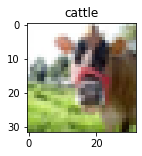

In [6]:
#Example image fine
i=0
label = y_train[i]
image = x_train[i]
plt.figure(figsize=(2,2))
plt.grid(False)
plt.title((fine_labels[int(label)]))
plt.imshow(image)
plt.show()

In [7]:
#Setting up logging files
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

#Creating layers
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same',
  input_shape=( 32, 32, 3)))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same',
  input_shape=( 32, 32, 3)))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same'))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),
  activation=tf.nn.relu,padding='same'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(units=100,activation=tf.nn.softmax))

#Compiling model using an Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

#Recording model checkpoints
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#Logging to tensorboard
tb_log = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#Creating early stopping where validation loss does not improve
#early_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

#Save best model weights based on validation accuracy
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

callbacks = [tb_log,
             #early_loss,
             mcp_save]

#Fitting model
model.fit(x_input, y_input, epochs=100,
  batch_size=64,
  callbacks=callbacks,
  validation_data=(x_valid, y_valid))

#Returning best weights
model.load_weights(filepath = '.mdl_wts.hdf5')

#Recording test accuracy
predictions = model.predict(x_valid)
y_pred = np.argmax(predictions,axis=-1)
print('test accuracy: ', np.sum(y_pred==y_test[:,0])/len(y_test))
## test accuracy: 0.3846

Epoch 1/100
782/782 [==============================] - 6s 8ms/step - loss: 4.2913 - accuracy: 0.0448 - val_loss: 3.8075 - val_accuracy: 0.1242
Epoch 2/100
782/782 [==============================] - 6s 7ms/step - loss: 3.8312 - accuracy: 0.1041 - val_loss: 3.4589 - val_accuracy: 0.1956
Epoch 3/100
782/782 [==============================] - 6s 7ms/step - loss: 3.5973 - accuracy: 0.1404 - val_loss: 3.2249 - val_accuracy: 0.2289
Epoch 4/100
782/782 [==============================] - 6s 7ms/step - loss: 3.4442 - accuracy: 0.1663 - val_loss: 3.1484 - val_accuracy: 0.2494
Epoch 5/100
782/782 [==============================] - 6s 7ms/step - loss: 3.3273 - accuracy: 0.1841 - val_loss: 2.9835 - val_accuracy: 0.2680
Epoch 6/100
782/782 [==============================] - 6s 8ms/step - loss: 3.2189 - accuracy: 0.2028 - val_loss: 2.8830 - val_accuracy: 0.2814
Epoch 7/100
782/782 [==============================] - 6s 8ms/step - loss: 3.1384 - accuracy: 0.2182 - val_loss: 2.8232 - val_accuracy: 0.2958

In [ ]:
#Examining loss on TensorBoard
%tensorboard --logdir logs/scalars

###Predicting fine labels using transfer learning

In [37]:
#Import VGG16 network
from keras.applications import VGG16
from keras.models import Model

In [35]:
#Reading in the model without the top layer and loading weights from imagenet
base_model = VGG16(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

In [55]:
#Setting up logging files
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

#Adding additional layers so that it can classify the CIFAR data
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=100,activation=tf.nn.softmax)
])

In [56]:
#Compiling model using an Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

#Recording model checkpoints
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#Logging to tensorboard
tb_log = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#Creating early stopping where validation loss does not improve
#early_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

#Save best model weights based on validation accuracy
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

callbacks = [tb_log,
             #early_loss,
             mcp_save]

#Fitting model
model.fit(x_input, y_input, epochs=100,
  batch_size=64,
  callbacks=callbacks,
  validation_data=(x_valid, y_valid))

#Returning best weights
model.load_weights(filepath = '.mdl_wts.hdf5')

#Recording test accuracy
predictions = model.predict(x_valid)
y_pred = np.argmax(predictions,axis=-1)
print('test accuracy: ', np.sum(y_pred==y_test[:,0])/len(y_test))
## test accuracy: 0.1546

Epoch 1/100
782/782 [==============================] - 3s 4ms/step - loss: 4.2909 - accuracy: 0.0920 - val_loss: 4.1969 - val_accuracy: 0.1073
Epoch 2/100
782/782 [==============================] - 3s 3ms/step - loss: 4.0131 - accuracy: 0.1332 - val_loss: 4.1575 - val_accuracy: 0.1145
Epoch 3/100
782/782 [==============================] - 3s 3ms/step - loss: 3.9265 - accuracy: 0.1461 - val_loss: 4.1031 - val_accuracy: 0.1298
Epoch 4/100
782/782 [==============================] - 3s 3ms/step - loss: 3.8766 - accuracy: 0.1558 - val_loss: 4.0464 - val_accuracy: 0.1312
Epoch 5/100
782/782 [==============================] - 3s 3ms/step - loss: 3.8283 - accuracy: 0.1652 - val_loss: 4.0563 - val_accuracy: 0.1314
Epoch 6/100
782/782 [==============================] - 3s 3ms/step - loss: 3.8092 - accuracy: 0.1664 - val_loss: 4.1223 - val_accuracy: 0.1377
Epoch 7/100
782/782 [==============================] - 3s 3ms/step - loss: 3.7645 - accuracy: 0.1752 - val_loss: 4.1384 - val_accuracy: 0.1364

In [ ]:
#Examining loss on TensorBoard
%tensorboard --logdir logs/scalars